In [2]:
import numpy as np
import torch

from captum.attr import IntegratedGradients
from captum.attr import LayerConductance
from captum.attr import NeuronConductance

import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

from scipy import stats
import pandas as pd

In [5]:
!wget http://biostat.mc.vanderbilt.edu/wiki/pub/Main/DataSets/titanic3.csv
# Update path to dataset here.
dataset_path = "titanic3.csv"

--2020-01-27 14:25:50--  http://biostat.mc.vanderbilt.edu/wiki/pub/Main/DataSets/titanic3.csv
Resolving biostat.mc.vanderbilt.edu (biostat.mc.vanderbilt.edu)... 160.129.37.119
Connecting to biostat.mc.vanderbilt.edu (biostat.mc.vanderbilt.edu)|160.129.37.119|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 116752 (114K) [text/csv]
Saving to: ‘titanic3.csv’

titanic3.csv        100%[===================>] 114.02K  58.7KB/s    in 1.9s    

2020-01-27 14:25:54 (58.7 KB/s) - ‘titanic3.csv’ saved [116752/116752]



In [14]:
# Read dataset from csv file.
titanic_data = pd.read_csv(dataset_path)
titanic_data.head()

,pclass,survived,name,sex,age,sibsp,parch,ticket,fare,cabin,embarked,boat,body,home.dest
0,1,1,"Allen, Miss. Elisabeth Walton",female,29.00,0,0,24160,211.3375,B5,S,2,NaN,"St Louis, MO"
1,1,1,"Allison, Master. Hudson Trevor",male,0.92,1,2,113781,151.5500,C22 C26,S,11,NaN,"Montreal, PQ / Chesterville, ON"
2,1,0,"Allison, Miss. Helen Loraine",female,2.00,1,2,113781,151.5500,C22 C26,S,NaN,NaN,"Montreal, PQ / Chesterville, ON"
3,1,0,"Allison, Mr. Hudson Joshua Creighton",male,30.00,1,2,113781,151.5500,C22 C26,S,NaN,135.0,"Montreal, PQ / Chesterville, ON"
4,1,0,"Allison, Mrs. Hudson J C (Bessie Waldo Daniels)",female,25.00,1,2,113781,151.5500,C22 C26,S,NaN,NaN,"Montreal, PQ / Chesterville, ON"


With the data loaded, we now preprocess the data by converting some categorical features such as gender, location of embarcation, and passenger class into one-hot encodings (separate feature columns for each class with 0 / 1). We also remove some features that are more difficult to analyze, such as name, and fill missing values in age and fare with the average values.

In [15]:
titanic_data = pd.concat([titanic_data,
                          pd.get_dummies(titanic_data['sex']),
                          pd.get_dummies(titanic_data['embarked'],prefix="embark"),
                          pd.get_dummies(titanic_data['pclass'],prefix="class")], axis=1)
titanic_data["age"] = titanic_data["age"].fillna(titanic_data["age"].mean())
titanic_data["fare"] = titanic_data["fare"].fillna(titanic_data["fare"].mean())
titanic_data = titanic_data.drop(['name','ticket','cabin','boat','body','home.dest','sex','embarked','pclass'], axis=1)

In [16]:
# Set random seed for reproducibility.
np.random.seed(131254)

# Convert features and labels to numpy arrays.
labels = titanic_data["survived"].to_numpy()
titanic_data = titanic_data.drop(['survived'], axis=1)
feature_names = list(titanic_data.columns)
data = titanic_data.to_numpy()

# Separate training and test sets using 
train_indices = np.random.choice(len(labels), int(0.7*len(labels)), replace=False)
test_indices = list(set(range(len(labels))) - set(train_indices))
train_features = data[train_indices]
train_labels = labels[train_indices]
test_features = data[test_indices]
test_labels = labels[test_indices]

We are now ready to define the neural network architecture we will use for the task. We have defined a simple architecture using 2 hidden layers, the first with 12 hidden units and the second with 8 hidden units, each with Sigmoid non-linearity. The final layer performs a softmax operation and has 2 units, corresponding to the outputs of either survived (1) or not survived (0).

In [17]:
import torch
import torch.nn as nn
torch.manual_seed(1)  # Set seed for reproducibility.
class TitanicSimpleNNModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.linear1 = nn.Linear(12, 12)
        self.sigmoid1 = nn.Sigmoid()
        self.linear2 = nn.Linear(12, 8)
        self.sigmoid2 = nn.Sigmoid()
        self.linear3 = nn.Linear(8, 2)
        self.softmax = nn.Softmax(dim=1)

    def forward(self, x):
        lin1_out = self.linear1(x)
        sigmoid_out1 = self.sigmoid1(lin1_out)
        sigmoid_out2 = self.sigmoid2(self.linear2(sigmoid_out1))
        return self.softmax(self.linear3(sigmoid_out2))

We can either use a pretrained model or train the network using the training data for 200 epochs. Note that the results of later steps may not match if retraining.

In [26]:
net = TitanicSimpleNNModel()
USE_PRETRAINED_MODEL = False

if USE_PRETRAINED_MODEL:
    net.load_state_dict(torch.load('models/titanic_model.pt'))
    print("Model Loaded!")
else:
    criterion = nn.CrossEntropyLoss()
    num_epochs = 2000

    optimizer = torch.optim.Adam(net.parameters(), lr=0.001)
    input_tensor = torch.from_numpy(train_features).type(torch.FloatTensor)
    label_tensor = torch.from_numpy(train_labels)
    for epoch in range(num_epochs):    
        output = net(input_tensor)
        loss = criterion(output, label_tensor)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        if epoch % 20 == 0:
            print ('Epoch {}/{} => Loss: {:.2f}'.format(epoch+1, num_epochs, loss.item()))

    torch.save(net.state_dict(), 'models/titanic_model_lr0001.pt')
    print("model training complete")

Epoch 1/2000 => Loss: 0.69
Epoch 21/2000 => Loss: 0.68
Epoch 41/2000 => Loss: 0.67
Epoch 61/2000 => Loss: 0.67
Epoch 81/2000 => Loss: 0.66
Epoch 101/2000 => Loss: 0.66
Epoch 121/2000 => Loss: 0.66
Epoch 141/2000 => Loss: 0.65
Epoch 161/2000 => Loss: 0.64
Epoch 181/2000 => Loss: 0.64
Epoch 201/2000 => Loss: 0.63
Epoch 221/2000 => Loss: 0.62
Epoch 241/2000 => Loss: 0.62
Epoch 261/2000 => Loss: 0.61
Epoch 281/2000 => Loss: 0.60
Epoch 301/2000 => Loss: 0.59
Epoch 321/2000 => Loss: 0.58
Epoch 341/2000 => Loss: 0.57
Epoch 361/2000 => Loss: 0.56
Epoch 381/2000 => Loss: 0.55
Epoch 401/2000 => Loss: 0.55
Epoch 421/2000 => Loss: 0.54
Epoch 441/2000 => Loss: 0.53
Epoch 461/2000 => Loss: 0.53
Epoch 481/2000 => Loss: 0.53
Epoch 501/2000 => Loss: 0.52
Epoch 521/2000 => Loss: 0.52
Epoch 541/2000 => Loss: 0.52
Epoch 561/2000 => Loss: 0.52
Epoch 581/2000 => Loss: 0.51
Epoch 601/2000 => Loss: 0.51
Epoch 621/2000 => Loss: 0.51
Epoch 641/2000 => Loss: 0.51
Epoch 661/2000 => Loss: 0.51
Epoch 681/2000 => Lo

In [27]:
out_probs = net(input_tensor).detach().numpy()
out_classes = np.argmax(out_probs, axis=1)
print("Train Accuracy:", sum(out_classes == train_labels) / len(train_labels))

Train Accuracy: 0.8406113537117904


In [28]:
test_input_tensor = torch.from_numpy(test_features).type(torch.FloatTensor)
out_probs = net(test_input_tensor).detach().numpy()
out_classes = np.argmax(out_probs, axis=1)
print("Test Accuracy:", sum(out_classes == test_labels) / len(test_labels))

Test Accuracy: 0.8040712468193384


In [29]:
ig = IntegratedGradients(net)

In [30]:
test_input_tensor.requires_grad_()
attr, delta = ig.attribute(test_input_tensor,target=1, return_convergence_delta=True)
attr = attr.detach().numpy()

Average Feature Importances
age :  -0.386
sibsp :  -0.057
parch :  -0.016
fare :  0.101
female :  0.074
male :  -0.309
embark_C :  0.045
embark_Q :  0.001
embark_S :  -0.090
class_1 :  0.077
class_2 :  0.027
class_3 :  -0.151


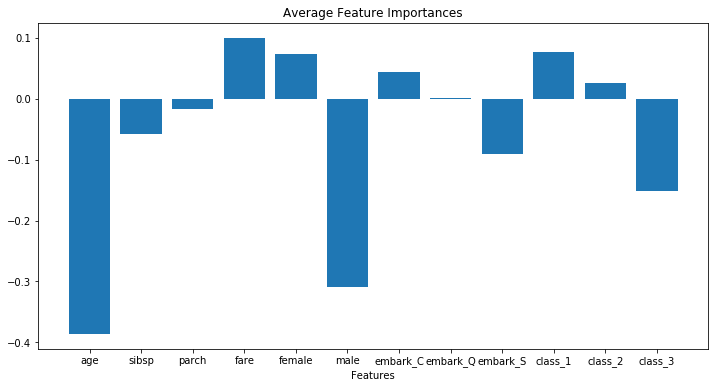

In [31]:
# Helper method to print importances and visualize distribution
def visualize_importances(feature_names, importances, title="Average Feature Importances", plot=True, axis_title="Features"):
    print(title)
    for i in range(len(feature_names)):
        print(feature_names[i], ": ", '%.3f'%(importances[i]))
    x_pos = (np.arange(len(feature_names)))
    if plot:
        plt.figure(figsize=(12,6))
        plt.bar(x_pos, importances, align='center')
        plt.xticks(x_pos, feature_names, wrap=True)
        plt.xlabel(axis_title)
        plt.title(title)
visualize_importances(feature_names, np.mean(attr, axis=0))

From the feature attribution information, we obtain some interesting insights regarding the importance of various features. We see that the strongest features appear to be age and being male, which are negatively correlated with survival. Embarking at Queenstown and the number of parents / children appear to be less important features generally.

An important thing to note is that the average attributions over the test set don't necessarilly capture all the information regarding feature importances. We should also look at the distribution of attributions for each feature. It is possible that features have very different attributions for different examples in the dataset.

For instance, we can visualize the distribution of attributions for sibsp, the number of siblings / spouses.

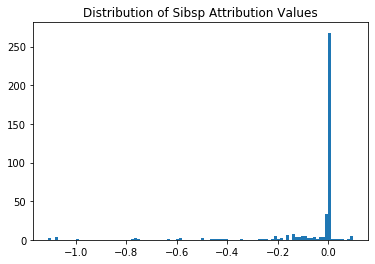

In [32]:
plt.hist(attr[:,1], 100);
plt.title("Distribution of Sibsp Attribution Values");

We note that a vast majority of the examples have an attribution value of 0 for sibsp, which likely corresponds to having a value of 0 for the feature (IntegratedGradients would provide an attribution of 0 when the feature value matches the baseline of 0). More significantly, we see that although the average seems smaller in magnitude in the plot above, there are a small number of examples with extremely negative attributions for this feature.

To better understand this, we can bucket the examples by the value of the sibsp feature and plot the average attribution for the feature. In the plot below, the size of the dot is proportional to the number of examples with that value.

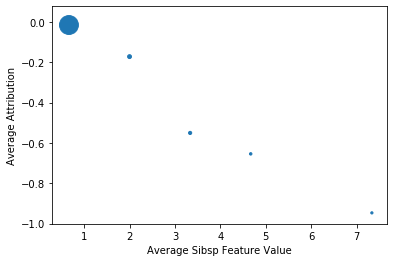

In [33]:
bin_means, bin_edges, _ = stats.binned_statistic(test_features[:,1], attr[:,1], statistic='mean', bins=6)
bin_count, _, _ = stats.binned_statistic(test_features[:,1], attr[:,1], statistic='count', bins=6)

bin_width = (bin_edges[1] - bin_edges[0])
bin_centers = bin_edges[1:] - bin_width/2
plt.scatter(bin_centers, bin_means, s=bin_count)
plt.xlabel("Average Sibsp Feature Value");
plt.ylabel("Average Attribution");

We see that the larger magnitude attributions correspond to the examples with larger Sibsp feature values, suggesting that the feature has a larger impact on prediction for these examples. Since there are substantially fewer of these examples (compared to those with a feature value of 0), the average attribution does not completely capture this effect.

Now that we have a better understanding of the importance of different input features, the next question we can ask regarding the function of the neural network is how the different neurons in each layer work together to reach the prediction. For instance, in our first hidden layer output containing 12 units, are all the units used for prediction? Do some units learn features positively correlated with survival while others learn features negatively correlated with survival?

This leads us to the second type of attributions available in Captum, Layer Attributions. Layer attributions allow us to understand the importance of all the neurons in the output of a particular layer. For this example, we will be using Layer Conductance, one of the Layer Attribution methods in Captum, which is an extension of Integrated Gradients applied to hidden neurons. More information regarding conductance can be found in the original paper here: https://arxiv.org/abs/1805.12233.

To use Layer Conductance, we create a LayerConductance object passing in the model as well as the module (layer) whose output we would like to understand. In this case, we choose net.sigmoid1, the output of the first hidden layer.

In [34]:
cond = LayerConductance(net, net.sigmoid1)

We can now obtain the conductance values for all the test examples by calling attribute on the LayerConductance object. LayerConductance also requires a target index for networks with mutliple outputs, defining the index of the output for which gradients are computed. Similar to feature attributions, we provide target = 1, corresponding to survival. LayerConductance also utilizes a baseline, but we simply use the default zero baseline as in integrated gradients.

In [35]:
cond_vals = cond.attribute(test_input_tensor,target=1)
cond_vals = cond_vals.detach().numpy()

Average Neuron Importances
0 :  -0.072
1 :  -0.044
2 :  -0.067
3 :  -0.023
4 :  -0.102
5 :  -0.084
6 :  -0.011
7 :  -0.001
8 :  -0.083
9 :  -0.058
10 :  -0.068
11 :  -0.063


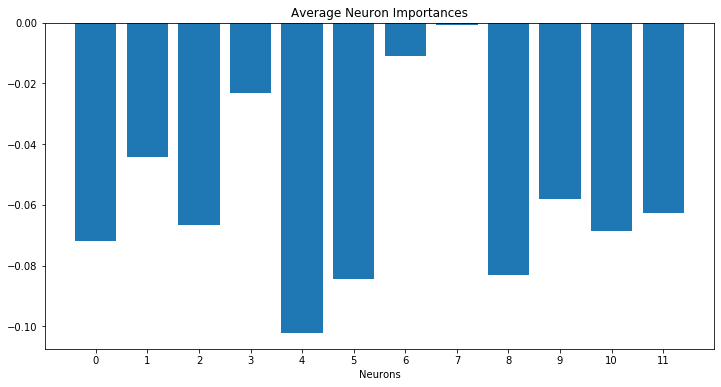

In [36]:
visualize_importances(range(12),np.mean(cond_vals, axis=0),title="Average Neuron Importances", axis_title="Neurons")

We can also look at the distribution of each neuron's attributions. Below we look at the distributions for neurons 7 and 9, and we can confirm that their attribution distributions are very close to 0, suggesting they are not learning substantial features.
Note due to retraining here we focus on neuron 7 only

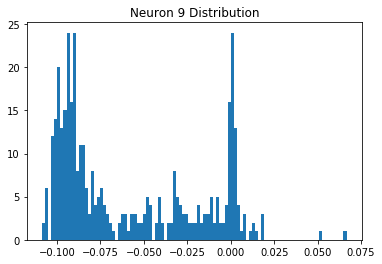

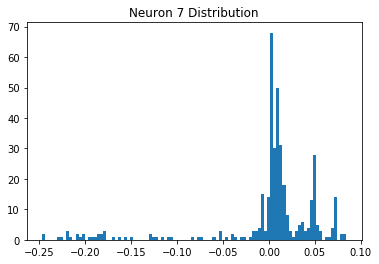

In [37]:
plt.hist(cond_vals[:,9], 100);
plt.title("Neuron 9 Distribution")
plt.figure()
plt.hist(cond_vals[:,7], 100);
plt.title("Neuron 7 Distribution");

Now, we can look at the distributions of neurons 0 and 10, which appear to be learning strong features negatively correlated with survival.

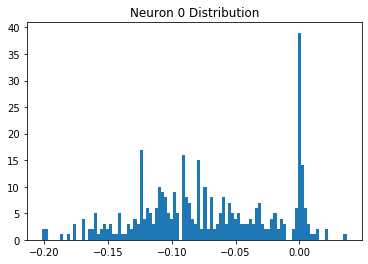

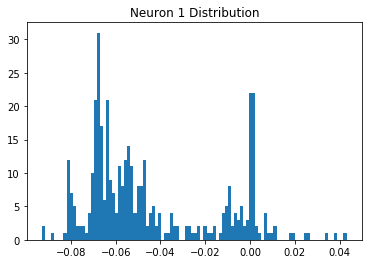

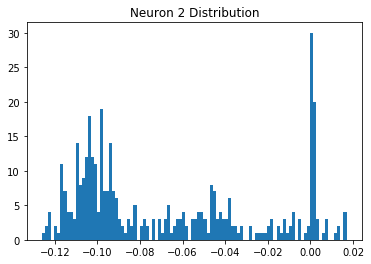

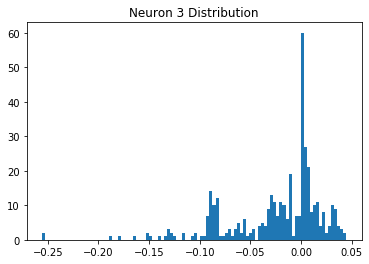

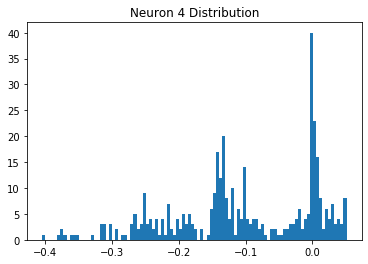

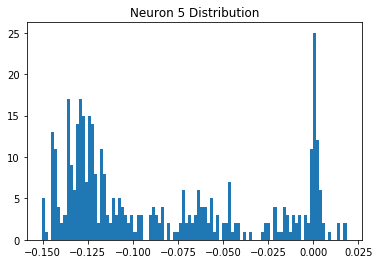

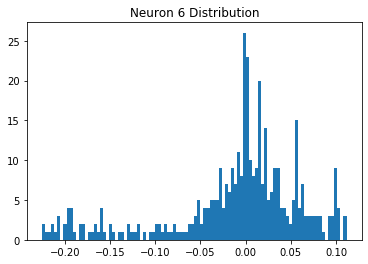

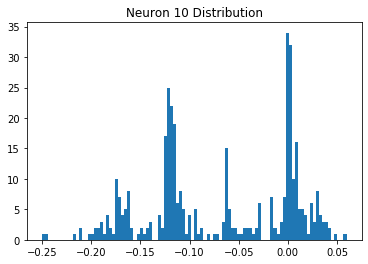

In [40]:
plt.hist(cond_vals[:,0], 100);
plt.title("Neuron 0 Distribution")
plt.figure()
plt.hist(cond_vals[:,1], 100);
plt.title("Neuron 1 Distribution")
plt.figure()
plt.hist(cond_vals[:,2], 100);
plt.title("Neuron 2 Distribution")
plt.figure()
plt.hist(cond_vals[:,3], 100);
plt.title("Neuron 3 Distribution")
plt.figure()
plt.hist(cond_vals[:,4], 100);
plt.title("Neuron 4 Distribution")
plt.figure()
plt.hist(cond_vals[:,5], 100);
plt.title("Neuron 5 Distribution")
plt.figure()
plt.hist(cond_vals[:,6], 100);
plt.title("Neuron 6 Distribution")
plt.figure()
plt.hist(cond_vals[:,10], 100);
plt.title("Neuron 10 Distribution");

We have identified that some of the neurons are not learning important features, while others are. Can we now understand what each of these important neurons are looking at in the input? For instance, are they identifying different features in the input or similar ones?

To answer these questions, we can apply the third type of attributions available in Captum, Neuron Attributions. This allows us to understand what parts of the input contribute to activating a particular input neuron. For this example, we will apply Neuron Conductance, which divides the neuron's total conductance value into the contribution from each individual input feature.

To use Neuron Conductance, we create a NeuronConductance object, analogously to Conductance, passing in the model as well as the module (layer) whose output we would like to understand, in this case, net.sigmoid1, as before.

In [41]:
neuron_cond = NeuronConductance(net, net.sigmoid1)

We can now obtain the neuron conductance values for all the test examples by calling attribute on the NeuronConductance object. Neuron Conductance requires the neuron index in the target layer for which attributions are requested as well as the target index for networks with mutliple outputs, similar to layer conductance. As before, we provide target = 1, corresponding to survival, and compute neuron conductance for neurons 0 and 10, the significant neurons identified above. The neuron index can be provided either as a tuple or as just an integer if the layer output is 1-dimensional.



In [42]:
neuron_cond_vals_10 = neuron_cond.attribute(test_input_tensor, neuron_index=10, target=1)

In [43]:
neuron_cond_vals_0 = neuron_cond.attribute(test_input_tensor, neuron_index=0, target=1)

Average Feature Importances for Neuron 0
age :  0.001
sibsp :  -0.002
parch :  -0.000
fare :  -0.035
female :  0.011
male :  -0.027
embark_C :  0.012
embark_Q :  -0.002
embark_S :  -0.006
class_1 :  0.010
class_2 :  0.001
class_3 :  -0.035


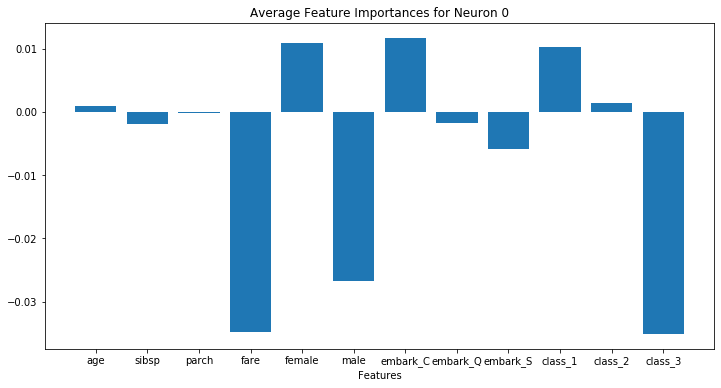

In [44]:
visualize_importances(feature_names, neuron_cond_vals_0.mean(dim=0).detach().numpy(), title="Average Feature Importances for Neuron 0")

From the data above, it appears that the primary input feature used by neuron 0 is age, with limited importance for all other features.

Average Feature Importances for Neuron 10
age :  -0.048
sibsp :  0.009
parch :  0.008
fare :  -0.004
female :  0.004
male :  -0.030
embark_C :  0.008
embark_Q :  0.003
embark_S :  -0.018
class_1 :  0.007
class_2 :  -0.005
class_3 :  -0.000


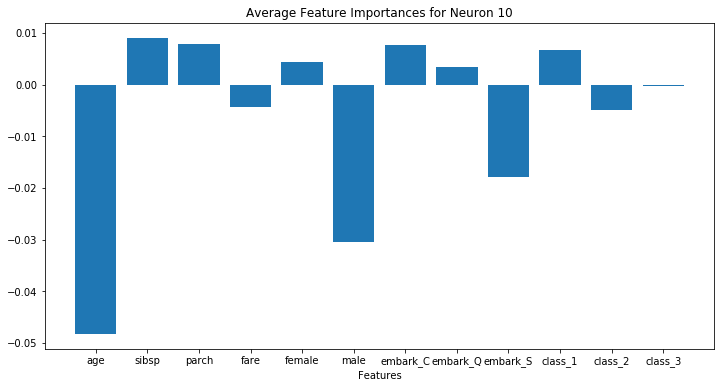

In [45]:
visualize_importances(feature_names, neuron_cond_vals_10.mean(dim=0).detach().numpy(), title="Average Feature Importances for Neuron 10")

From the visualization above, it is evident that neuron 10 primarily relies on the gender and class features, substantially different from the focus of neuron 0.